## Prerequisites:

**Satellite image classificaion with deep learning | CNN, transfer learning & grad-CAM explained**: <br>

- https://www.youtube.com/watch?v=1veMRCIG7a8

**Used Dataset**:

- https://huggingface.co/datasets/blanchon/EuroSAT_RGB/viewer/default/train

In [6]:
%pip -q uninstall -y sklearn-compat || true
%pip -q install -U "scikit-learn>=1.5,<1.8" "tensorflow>=2.15,<3" "tensorflow-datasets>=4.9,<5" matplotlib pandas \
"gradio>=4.44,<5" onnx onnxruntime "keras-tuner>=1.4.6,<2" "datasets>=2.0" "huggingface-hub>=0.20"

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Environment and GPU check
import sys, platform
import tensorflow as tf
import sklearn

print("Python version: ", sys.version.split()[0])
print("TensorFlow version: ", tf.__version__)
print("sklearn version: ", sklearn.__version__)
print("Platform: ", platform.platform())
print("GPU: ", tf.config.list_physical_devices("GPU"))

# Optional: enable mixed precision for newer GPUs
USE_MIXED_PRECISION = False

if USE_MIXED_PRECISION:
  from tensorflow.keras import mixed_precision
  mixed_precision.set_global_policy("mixed_float16")
  print("Mixed precision enabled.")

Python version:  3.12.3
TensorFlow version:  2.20.0
sklearn version:  1.7.2
Platform:  Windows-11-10.0.26200-SP0
GPU:  []


In [ ]:
import os, math, random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

SEED = 42
IMG_SIZE = 128 
BATCH_SIZE = 16  # колко вижда модела
EPOCHS_BASELINE = 8  # бройка итерации през изображението
EPOCHS_TRANSFER = 8
AUTOTUNE = tf.data.AUTOTUNE
tf.keras.utils.set_random_seed(SEED)

plt.rcParams["figure.figsize"] = (6, 4)

print("Configured IMG_SIZE: ", IMG_SIZE, " | BATCH_SIZE: ", BATCH_SIZE)


Configured IMG_SIZE:  128  | BATCH_SIZE:  16


In [ ]:
# Download EuroSAT - try TFDS first, fallback to Hugging Face if blocked
try:
    builder = tfds.builder("eurosat/rgb")
    builder.download_and_prepare()
    info = builder.info
    NUM_CLASSES = info.features["label"].num_classes
    CLASS_NAMES = info.features["label"].names
    print("Classes: ", CLASS_NAMES)
    
    SPLIT_TRAIN = 0.7
    SPLIT_VAL = 0.15
    
    total = info.splits["train"].num_examples
    n_train = int(total * SPLIT_TRAIN)
    n_val = int(total * SPLIT_VAL)
    n_test = total - n_train - n_val
    print(f"Total: {total} | n_train: {n_train} | n_val: {n_val} | n_test: {n_test}")
    
    USE_TFDS = True

# Fallback to Hugging face if an error occurs with tfds
except Exception as e:
    print(f"TFDS download failed: {e}")
    print("Downloading from Hugging Face instead...")
    
    from datasets import load_dataset
    from PIL import Image
    import io
    
    hf_dataset = load_dataset("cm93/eurosat", split="train")
    
    # EuroSAT class names (in order)
    CLASS_NAMES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
    NUM_CLASSES = len(CLASS_NAMES)
    
    # Hugging Face uses numeric labels 0-9, map them to class names
    # The dataset should have features that tell us the label names, but if not, 
    # we'll use the standard EuroSAT class order
    label_to_idx = {i: i for i in range(NUM_CLASSES)}  # 0->0, 1->1, etc.
    print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")
    
    images_list = []
    labels_list = []
    for item in hf_dataset:
        # Image is already a PIL Image, convert to RGB and then to numpy
        img = item["image"].convert('RGB')
        img_array = np.array(img, dtype=np.uint8)
        images_list.append(img_array)
        labels_list.append(label_to_idx[item["label"]])
    
    all_images = np.array(images_list, dtype=np.uint8)
    all_labels = np.array(labels_list, dtype=np.int32)
    total = len(all_images)
    
    SPLIT_TRAIN = 0.7
    SPLIT_VAL = 0.15
    
    n_train = int(total * SPLIT_TRAIN)
    n_val = int(total * SPLIT_VAL)
    n_test = total - n_train - n_val
    
    # Shuffle with seed
    indices = np.arange(total)
    np.random.seed(SEED)
    np.random.shuffle(indices)
    
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train+n_val]
    test_indices = indices[n_train+n_val:]
    
    # Create tf.data.Dataset objects
    train_raw = tf.data.Dataset.from_tensor_slices((all_images[train_indices], all_labels[train_indices]))
    val_raw = tf.data.Dataset.from_tensor_slices((all_images[val_indices], all_labels[val_indices]))
    test_raw = tf.data.Dataset.from_tensor_slices((all_images[test_indices], all_labels[test_indices]))
    
    print(f"Total: {total} | n_train: {n_train} | n_val: {n_val} | n_test: {n_test}")
    USE_TFDS = False

def get_splits():
    if USE_TFDS:
        full = tfds.load("eurosat/rgb", split="train", as_supervised=True)
        train = full.take(n_train)
        rest = full.skip(n_train)
        val = rest.take(n_val)
        test = rest.skip(n_val)
        return train, val, test
    else:
        return train_raw, val_raw, test_raw

# Initialize datasets if using TFDS
if USE_TFDS:
    train_raw, val_raw, test_raw = get_splits()

def preprocess(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf.image.random_contrast(image, 0.9, 1.1)
  return image, label

train = (train_raw
         .map(preprocess, num_parallel_calls=AUTOTUNE)
         .cache()
         .shuffle(2048, seed=SEED)
         .map(augment, num_parallel_calls=AUTOTUNE)
         .batch(BATCH_SIZE)
         .prefetch(AUTOTUNE))

val = (val_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

test = (test_raw
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE))

steps_train = math.ceil(n_train / BATCH_SIZE)
steps_val = math.ceil(n_val / BATCH_SIZE)
steps_test = math.ceil(n_test / BATCH_SIZE)
(n_train, n_val, n_test, steps_train, steps_val, steps_test)

Dl Completed...: 0 url [00:00, ? url/s]


Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]
Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]

TFDS download failed: Failed to get url http://madm.dfki.de/files/sentinel/EuroSAT.zip. HTTP code: 403.



c:\Users\HP ZBook 17 G5\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP ZBook 17 G5\.cache\huggingface\hub\datasets--cm93--eurosat. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 2700/2700 [00:00<00:00, 90201.52 example

Classes (10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total: 21600 | n_train: 15119 | n_val: 3240 | n_test: 3241


(15119, 3240, 3241, 945, 203, 203)

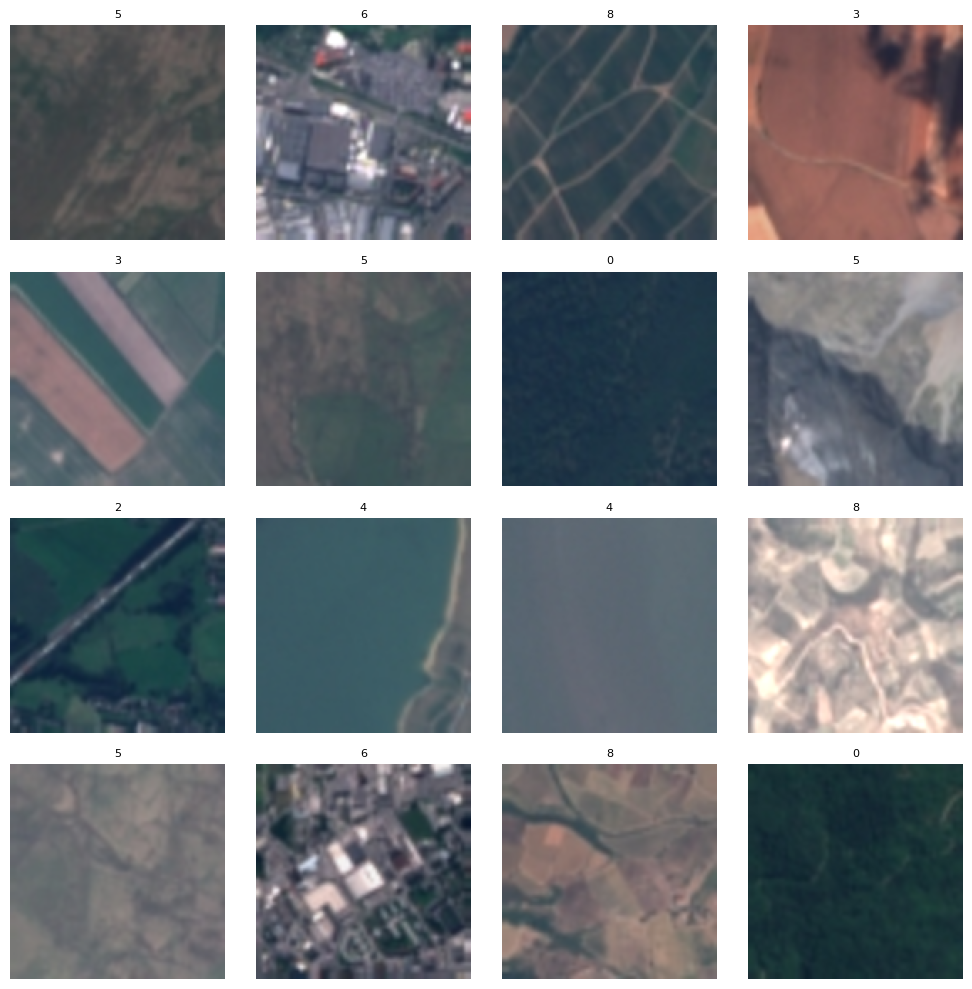

In [ ]:
def show_batch(ds, n=16):
  images, labels = next(iter(ds.take(1)))
  s = int(np.ceil(np.sqrt(n)))
  plt.figure(figsize=(10, 10))
  idxs = np.random.choice(range(images.shape[0]), min(n, images.shape[0]), replace=False)
  
  for i, idx in enumerate(idxs):
    plt.subplot(s, s, i + 1)
    plt.imshow(images[idx])
    plt.title(CLASS_NAMES[int(labels[idx])], fontsize=8)
    plt.axis("off")
  
  plt.tight_layout()
  plt.show()

show_batch(train, n=16)

In [ ]:
# CNN from scratch
from tensorflow.keras import layers, models, callbacks

def build_small_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
  inputs = layers.Input(shape=input_shape)

  # layer 1
  x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D()(x)

  # layer 2
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D()(x)

  # layer 3
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D()(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x) # Колко от информацията бива изключена чрез dropout
  outputs = layers.Dense(num_classes, activation="softmax")(x)
  model = models.Model(inputs, outputs, name="small_cnn")
  return model

baseline = build_small_cnn()
baseline.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

es = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy")
rlr = callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1, monitor="val_loss")

hist_baseline = baseline.fit(train, validation_data=val, epochs=EPOCHS_BASELINE, callbacks=[es, rlr])

Epoch 1/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 278s 291ms/step - accuracy: 0.5555 - loss: 1.2707 - val_accuracy: 0.5688 - val_loss: 1.1753 - learning_rate: 0.0010
Epoch 2/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 244s 258ms/step - accuracy: 0.6904 - loss: 0.8842 - val_accuracy: 0.1509 - val_loss: 15.1910 - learning_rate: 0.0010
Epoch 3/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7369 - loss: 0.7594
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
945/945 ━━━━━━━━━━━━━━━━━━━━ 216s 228ms/step - accuracy: 0.7511 - loss: 0.7239 - val_accuracy: 0.5194 - val_loss: 1.8267 - learning_rate: 0.0010
Epoch 4/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 215s 227ms/step - accuracy: 0.8049 - loss: 0.5706 - val_accuracy: 0.8241 - val_loss: 0.5059 - learning_rate: 5.0000e-04
Epoch 5/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 177s 187ms/step - accuracy: 0.8258 - loss: 0.5154 - val_accuracy: 0.8528 - val_loss: 0.4370 - learning_rate: 5.0000e-04
Epoch 6/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 177s 188ms/step - accura

In [ ]:
BACKBONE = "MobileNetV2"
LR = 3e-4  # Learning rate
FREEZE_BACKBONE = True

if BACKBONE == "MobileNetV2":
  base = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights="imagenet",
      input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )
  preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

elif BACKBONE == "EfficientNetB0":
  base = tf.keras.applications.EfficientNetB0(
      include_top=False,
      weights="imagenet",
      input_shape=(IMG_SIZE, IMG_SIZE, 3)
  )
  preprocess_input = tf.keras.applications.efficientnet.preprocess_input

if FREEZE_BACKBONE:
  base.trainable = False

def preprocess_for_transfer(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32) * 255.0
  image = preprocess_input(image)
  return image, label

# Recreate raw splits deterministically, then map transfer preprocessing
# Define get_splits() if it doesn't exist (in case earlier cells weren't run)
if 'get_splits' not in globals():
    def get_splits():
      if 'USE_TFDS' in globals() and USE_TFDS:
          full = tfds.load("eurosat/rgb", split="train", as_supervised=True)
          train = full.take(n_train)
          rest = full.skip(n_train)
          val = rest.take(n_val)
          test = rest.skip(n_val)
          return train, val, test
      
      elif 'train_raw' in globals() and 'val_raw' in globals() and 'test_raw' in globals():
          # Return the already-created datasets
          return train_raw, val_raw, test_raw
      
      else:
          raise RuntimeError("Dataset not loaded. Please run the dataset loading cell first.")

train_raw_t, val_raw_t, test_raw_t = get_splits()

train_t = (train_raw_t
  .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
  .cache()
  .shuffle(2048, seed=SEED)
  .batch(BATCH_SIZE)
  .prefetch(AUTOTUNE))

val_t = (val_raw_t
         .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
         .cache()
         .batch(BATCH_SIZE)
         .prefetch(AUTOTUNE))

test_t = (test_raw_t
          .map(preprocess_for_transfer, num_parallel_calls=AUTOTUNE)
          .cache()
          .batch(BATCH_SIZE)
          .prefetch(AUTOTUNE))

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
transfer = tf.keras.Model(inputs, outputs, name=f"transfer_{BACKBONE}")

transfer.compile(
    optimizer=tf.keras.optimizers.Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

hist_transfer = transfer.fit(
  train_t,
  validation_data=val_t,
  epochs=EPOCHS_TRANSFER,
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 155s 160ms/step - accuracy: 0.6682 - loss: 0.9484 - val_accuracy: 0.7194 - val_loss: 0.7788
Epoch 2/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 191s 202ms/step - accuracy: 0.7395 - loss: 0.7290 - val_accuracy: 0.7373 - val_loss: 0.7523
Epoch 3/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 187s 198ms/step - accuracy: 0.7597 - loss: 0.6687 - val_accuracy: 0.7522 - val_loss: 0.7069
Epoch 4/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 184s 195ms/step - accuracy: 0.7723 - loss: 0.6340 - val_accuracy: 0.7556 - val_loss: 0.6911
Epoch 5/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 186s 197ms/step - accuracy: 0.7783 - loss: 0.6089 - val_accuracy: 0.7818 - val_loss: 0.6479
Epoch 6/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 183s 193ms/step - accuracy: 0.7880 - loss: 0.5888 - val_accuracy: 0.7586 - val_loss: 0.6875
Epoch 7/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 179s 190ms/step - accuracy: 0.7917 - loss: 0.5760 - val_accuracy: 0.7571 - val_loss: 0.6912
Epoch 8/8
945/945 ━━━━━━━━━━━━━━━━━━━━ 177s 188ms/step - accuracy: 0.7979 - loss: 0

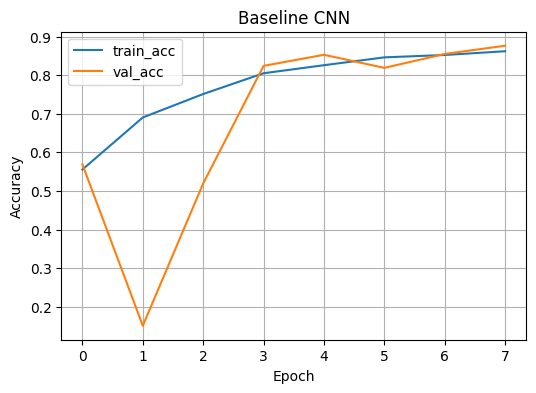

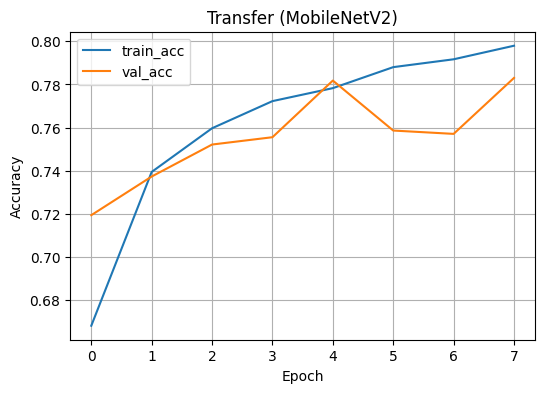

In [16]:
def plot_history(h, title):
  plt.figure()
  plt.plot(h.history["accuracy"], label="train_acc")
  plt.plot(h.history["val_accuracy"], label="val_acc")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(title)
  plt.legend()
  plt.grid(True)
  plt.show()

plot_history(hist_baseline, "Baseline CNN")
plot_history(hist_transfer, f"Transfer ({BACKBONE})")

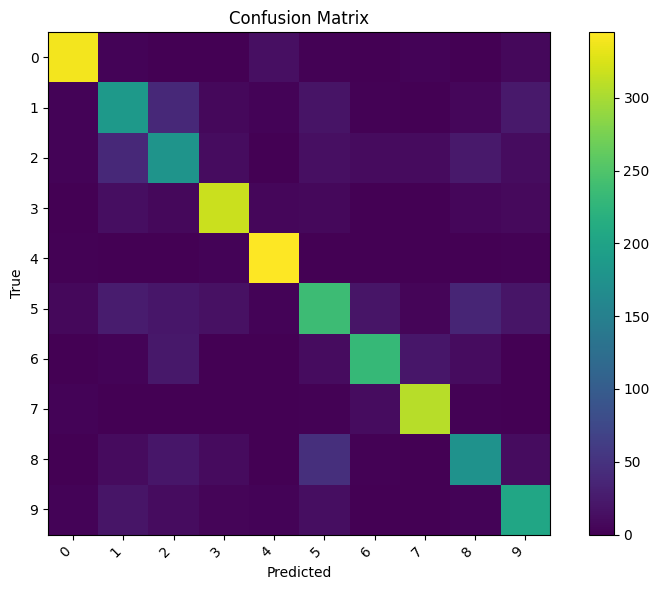

Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       370
           1       0.61      0.64      0.62       291
           2       0.59      0.59      0.59       301
           3       0.86      0.86      0.86       367
           4       0.92      0.97      0.95       354
           5       0.68      0.61      0.64       390
           6       0.84      0.77      0.80       300
           7       0.89      0.94      0.91       327
           8       0.66      0.63      0.65       278
           9       0.71      0.78      0.74       263

    accuracy                           0.78      3241
   macro avg       0.77      0.77      0.77      3241
weighted avg       0.78      0.78      0.78      3241



,class,accuracy
0,4,0.974576
1,7,0.941896
2,0,0.916216
3,3,0.863760
4,9,0.775665
5,6,0.770000
6,1,0.635739
7,8,0.633094
8,5,0.605128
9,2,0.594684


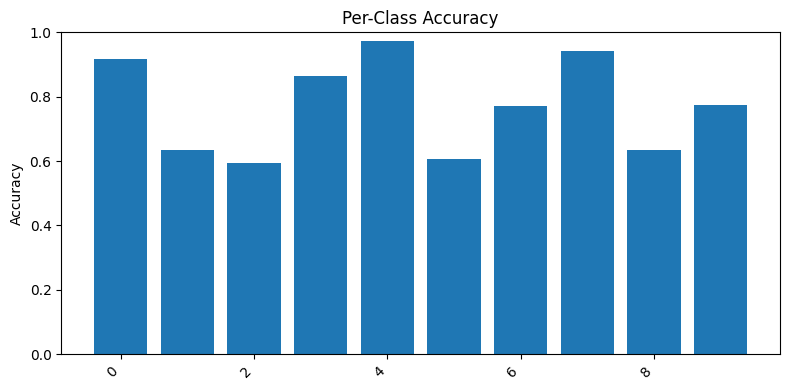

In [18]:
def get_preds_and_labels(model, ds):
  y_true, y_pred = [], []
  for images, labels in ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())
  return np.array(y_true), np.array(y_pred)

# Choose which model/dataset to evaluate
EVAL_MODEL = "transfer"
model_to_eval = baseline if EVAL_MODEL == "baseline" else transfer
ds_to_eval = test if EVAL_MODEL == "baseline" else test_t

y_true, y_pred = get_preds_and_labels(model_to_eval, ds_to_eval)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig = plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=range(NUM_CLASSES), labels=CLASS_NAMES, rotation=45, ha="right")
plt.yticks(ticks=range(NUM_CLASSES), labels=CLASS_NAMES)
plt.colorbar()
plt.tight_layout()
plt.show()

print("Classification Report: ")
class_names_str = [str(name) for name in CLASS_NAMES] if CLASS_NAMES else None
print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)), target_names=class_names_str))

# Per-class accuracy
acc_per_class = []
for c in range(NUM_CLASSES):
  idx = (y_true == c)
  acc = float((y_pred[idx] == c).mean()) if idx.sum() else 0.0
  acc_per_class.append({"class": CLASS_NAMES[c], "accuracy": acc})

df_acc = pd.DataFrame(acc_per_class)\
  .sort_values("accuracy", ascending=False)\
  .reset_index(drop=True)
display(df_acc)

plt.figure(figsize=(8, 4))
plt.bar(df_acc["class"], df_acc["accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
def show_predictions_grid(model, ds, n=16, transfer_mode=False):
  images, labels = next(iter(ds.take(1)))
  preds = model.predict(images, verbose=0)
  preds = np.argmax(preds, axis=1)
  s = int(np.ceil(np.sqrt(n)))
  plt.figure(figsize=(10, 10))
  idxs = np.random.choice(range(images.shape[0]), min(n, images.shape[0]), replace=False)

  for i, idx in enumerate(idxs):
    plt.subplot(s, s, i + 1)
    img = images[idx]
  
    if transfer_mode:
      # inputs are preprocessed; rescale for display if necessary
      # Try to bring to [0, 1] heuristically
      disp = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-9)
      plt.imshow(disp.numpy())
  
    else:
      plt.imshow(img)

    t = CLASS_NAMES[int(labels[idx])]
    p = CLASS_NAMES[int(preds[idx])]
    title = f"T: {t} | P: {p}"
    plt.title(title, fontsize=8)
    plt.axis("off")
    
  plt.tight_layout()
  plt.show()

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

def build_gradcam_probe(model: tf.keras.Model):
  input_shape = model.input_shape[1:]
  inp = tf.keras.Input(shape=input_shape)

  backbone = None
  for lyr in model.layers:
    if isinstance(lyr, tf.keras.Model):
      backbone = lyr
      break

  if backbone is not None:
    fmap = backbone(inp, training=False)
    idx = model.layers.index(backbone)
    x = fmap
    for layer in model.layers[idx + 1:]:
      x = layer(x, training=False)
    preds = x

    preprocess = (tf.keras.applications.mobilenet_v2.preprocess_input
                  if "MobileNetV2" in backbone.name or "mobilenetv2" in backbone.name.lower()
                  else tf.keras.applications.efficientnet.preprocess_input)
    display_needs_scale = True
  else:
    fmap = None
    x = inp
    last_conv_idx = -1
    for i, layer in enumerate(model.layers):
      x = layer(x, training=False)
      if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        fmap = x
        last_conv_idx = i
    if fmap is None:
      raise ValueError("No conv layers found. Train a CNN or use the transfer model.")
    preds = x

    preprocess = lambda z : z
    display_needs_scale = False

  probe = tf.keras.Model(inp, [fmap, preds], name="gradcam_probe")
  return probe, preprocess, display_needs_scale

def gradcam_heatmap_from_probe(probe, img_array):
  with tf.GradientTape() as tape:
    fmap, predictions = probe(img_array, training=False)
    top_index = tf.argmax(predictions[0])
    loss = predictions[:, top_index]
  grads = tape.gradient(loss, fmap)
  pooled = tf.reduce_mean(grads, axis=(0, 1, 2))
  fmap0 = fmap[0]
  heat = fmap0 @ pooled[..., tf.newaxis]
  heat = tf.squeeze(heat)
  heat = tf.maximum(heat, 0) / (tf.math.reduce_max(heat) + 1e-9)
  return heat.numpy()

try:
  model_to_eval
except NameError:
  try:
    model_to_eval = transfer
  except NameError:
    model_to_eval = baseline

# Build the probe model safely
probe, preprocess_input, scale_display = build_gradcam_probe(model_to_eval)

# Pull one raw image - use the appropriate source based on USE_TFDS flag
if USE_TFDS:
  raw_one = tfds.load("eurosat/rgb", split="train", as_supervised=True).take(1)
  raw_img, _ = next(iter(raw_one))
else:
  # Use Hugging Face data - get one sample from train_raw
  raw_img, _ = next(iter(train_raw.take(1)))

raw_img_resized = tf.image.resize(raw_img, (IMG_SIZE, IMG_SIZE))

display_img = tf.cast(raw_img_resized, tf.float32) / 255.0
if scale_display:
  # transfer models expect Imagenet preprocess on 0...255
  model_img = preprocess_input(tf.expand_dims(tf.cast(raw_img_resized, tf.float32), 0))
else:
  model_img = tf.expand_dims(display_img, 0)

# Compute heatmap
heatmap = gradcam_heatmap_from_probe(probe, model_img)

# Resize to IMG_SIZE and overlay
heatmap_tf = tf.image.resize(heatmap[..., None], (IMG_SIZE, IMG_SIZE)).numpy().squeeze()
hmin, hmax = heatmap_tf.min(), heatmap_tf.max()
heatmap_norm = (heatmap_tf - hmin) / (hmax - hmin + 1e-9)

overlay = (0.4 * np.stack([heatmap_norm] * 3, axis=-1) + 0.6 * display_img.numpy()).clip(0, 1)

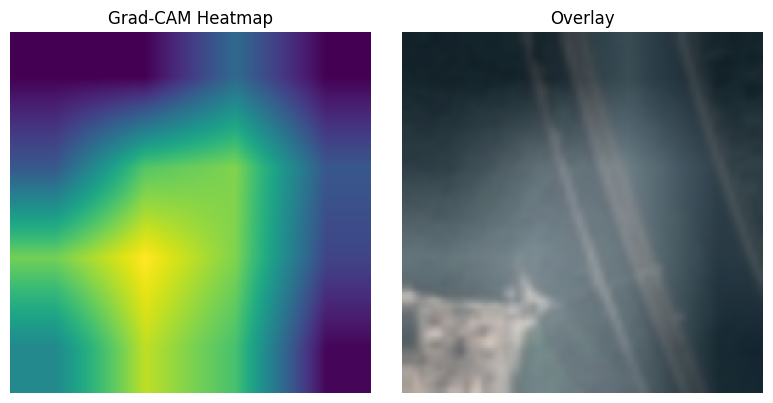

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); plt.imshow(heatmap_norm); plt.title("Grad-CAM Heatmap"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.tight_layout()
plt.show()